In [1]:
import psutil
import numpy as np
import pandas as pd
import multiprocessing as mp
import pickle as pkl
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn import linear_model


from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.preprocessing import scale
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.cluster import DBSCAN
from mlxtend.plotting import plot_linear_regression
from sklearn.decomposition import PCA 


In [2]:
csc_df = pd.DataFrame(pd.read_csv("data_files/Most-Recent-Cohorts-Scorecard-Elements.csv"))
# Removing irrelevant features
csc_df = csc_df.drop(csc_df.columns[[0,1,2,6,7]], axis=1)
csc_df.head()

,INSTNM,CITY,STABBR,HCM2,PREDDEG,HIGHDEG,CONTROL,LOCALE,HBCU,PBI,...,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GT_25K_P6,GT_28K_P6,GRAD_DEBT_MDN_SUPP,GRAD_DEBT_MDN10YR_SUPP,RPY_3YR_RT_SUPP,C150_L4_POOLED_SUPP,C150_4_POOLED_SUPP
0,Alabama A & M University,Normal,AL,0,3,4,1,12.0,1.0,0.0,...,0.7667,0.0859,31000,0.453,0.431,32750,348.16551225731,0.2531554273,NaN,0.2913
1,University of Alabama at Birmingham,Birmingham,AL,0,3,4,1,12.0,0.0,0.0,...,0.5179,0.2363,41200,0.669,0.631,21833,232.106797835537,0.513963161,NaN,0.5384
2,Amridge University,Montgomery,AL,0,3,4,2,12.0,0.0,0.0,...,0.8436,0.8571,39600,0.658,0.542,22890,243.343773299842,0.2307692308,NaN,PrivacySuppressed
3,University of Alabama in Huntsville,Huntsville,AL,0,3,4,1,12.0,0.0,0.0,...,0.4312,0.2255,46700,0.685,0.649,22647,240.760438353933,0.5485090298,NaN,0.4905
4,Alabama State University,Montgomery,AL,0,3,4,1,12.0,1.0,0.0,...,0.8113,0.0974,27700,0.393,0.351,31500,334.876752247489,0.2185867473,NaN,0.2475


In [3]:
# Removing schools not in current operation
csc_df = csc_df.drop(csc_df[csc_df['CURROPER'] == 0].index)
print(csc_df.shape)

# Replacing PrivacySuppressed with NaN
csc_df = csc_df.replace('PrivacySuppressed', np.nan)
print(csc_df.shape)


# For clustering
numeric_school_data = csc_df.iloc[:,3:]

#------------------------------------------------------------------------------
# This next section will impute the data, and verify the integrity of the data.
#------------------------------------------------------------------------------

# Resolving any NaN values using Imputation
# Credit to O.rka at https://stackoverflow.com/questions/33660836/impute-entire-dataframe-all-columns-using-scikit-learn-sklearn-without-itera
fill_NaN = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_df = pd.DataFrame(fill_NaN.fit_transform(numeric_school_data))
imputed_df.columns = numeric_school_data.columns
imputed_df.index = numeric_school_data.index

# Check for incorrect column types
for i in range(len(imputed_df.dtypes)):
    if imputed_df.dtypes[i] != imputed_df.dtypes[1]:
        print(imputed_df.dtypes[i])

print("No other bad dtypes.")

# Check for NaN values
imputed_df.isnull().values.any()

print("No other NaN values.")

print(np.where(np.isnan(imputed_df)))

for i in range(len(imputed_df.columns)):
    for j in range(len(imputed_df.index)):
        if np.isfinite(imputed_df.iloc[j,i]) == False:
            print(j,i)
            print(imputed_df.iloc[j,i])

print("No other non-finite values.")


#imputed_df[imputed_df['INSTNM'] == 'University of Utah']

print("All Schools:", imputed_df.shape)

# Splitting into main groups
public_schools_df = imputed_df[imputed_df['CONTROL'] == 1]
print("Public Schools:", public_schools_df.shape)
private2_schools_df = imputed_df[imputed_df['CONTROL'] == 2]
print("Private NP Schools:", private2_schools_df.shape)
private3_schools_df = imputed_df[imputed_df['CONTROL'] == 3]
print("Private FP Schools:", private3_schools_df.shape)

#put dataframes into pickle objects
imputed_df.to_pickle("allschools_df.pkl")
public_schools_df.to_pickle("public_df.pkl")
private2_schools_df.to_pickle("nonprofit_df.pkl")
private3_schools_df.to_pickle("forprofit_df.pkl")

(6692, 119)
(6692, 119)
No other bad dtypes.
No other NaN values.
(array([], dtype=int64), array([], dtype=int64))
No other non-finite values.
All Schools: (6692, 116)
Public Schools: (2047, 116)
Private NP Schools: (1925, 116)
Private FP Schools: (2720, 116)


## PCA for All Schools

The first 3 components explain 72.81% of the variance in this data.

These are the principle components that explain more tha 0.1% of variance
[0.36428827485677057, 0.20062839025049264, 0.16314809539637065, 0.08901131367457354, 0.07498607589025415, 0.031676843660883615, 0.01880557873121645, 0.015009714510897628, 0.01405295744056193, 0.01159948374141188, 0.00674317297325938, 0.0041707918428212695, 0.0026106653887032327, 0.0019012429053593513, 0.00117640384595218]


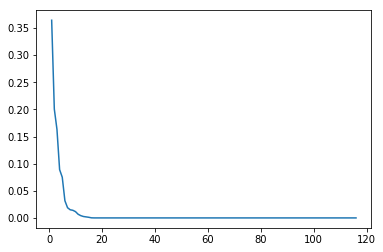

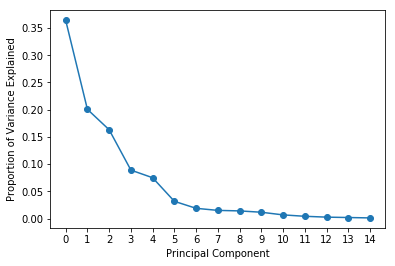

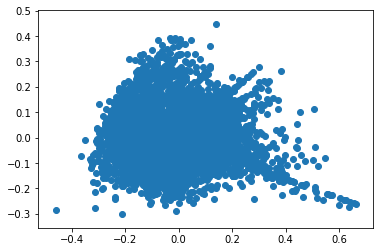

In [4]:
normalized_X = preprocessing.normalize(imputed_df)
pca_model = PCA()
snsd_PCA = pca_model.fit_transform(normalized_X)

print("The first 3 components explain ",end="")
print(round((pca_model.explained_variance_ratio_[0]+
       pca_model.explained_variance_ratio_[1]+
       pca_model.explained_variance_ratio_[2]),4)*100,
       "%",sep="",end="")
print(" of the variance in this data.")

# Plotting the explained variance for each principle component
list_of_PCA_variances = []
for i in range(len(pca_model.explained_variance_ratio_)):
    list_of_PCA_variances.append(pca_model.explained_variance_ratio_[i])
    
print("\nThese are the principle components that explain more tha 0.1% of variance")
components_to_use = []
for variance in list_of_PCA_variances:
    if variance > 0.001:
        components_to_use.append(variance)
print(components_to_use)

# This shows an extreme drop off for variances, which infers that we do not need a majority of these columns
# for clustering
plt.plot(np.linspace(1, len(pca_model.explained_variance_ratio_), 116), list_of_PCA_variances)
plt.show()
plt.plot(list(range(len(components_to_use))), components_to_use, '-o')
plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xticks(list(range(len(components_to_use))))
plt.show()
plt.scatter(snsd_PCA[:,0],snsd_PCA[:,1])
plt.show()

PCA_DF = pd.DataFrame(snsd_PCA[:,0:7], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'], 
                      index=list(csc_df.iloc[:,0]))

#all schools PCA into pickle object

PCA_DF.to_pickle("allschoolsPCA.pkl")

## PCA for Public Schools

The first 3 components explain 80.333% of the variance in the data for public schools.

These are the principle components that explain more tha 0.1% of variance in public school data
[0.36824233404057527, 0.26571020129379247, 0.16937570307303554, 0.11626353265260689, 0.034777207612942805, 0.015998759975157876, 0.010207923660697546, 0.00956667443731389, 0.006342153310370581, 0.003469717221030775]


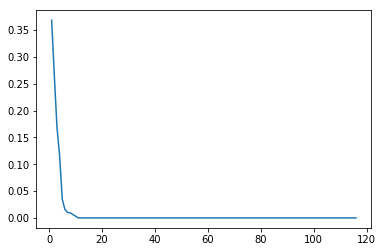

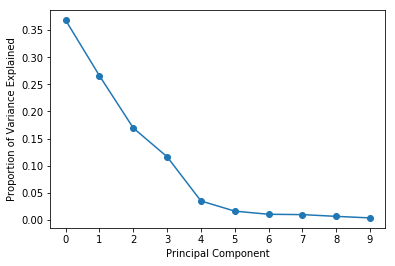

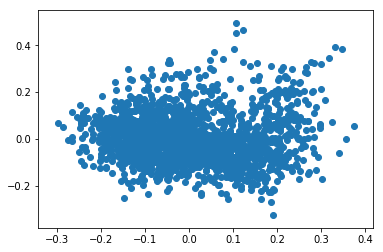

In [5]:
normalized_X_pub = preprocessing.normalize(public_schools_df)
pca_pub_model = PCA()
pub_PCA = pca_pub_model.fit_transform(normalized_X_pub)

print("The first 3 components explain ",end="")
print(round((pca_pub_model.explained_variance_ratio_[0]+
       pca_pub_model.explained_variance_ratio_[1]+
       pca_pub_model.explained_variance_ratio_[2]),5)*100,
       "%",sep="",end="")
print(" of the variance in the data for public schools.")

# Plotting the explained variance for each principle component
list_pub_PCA_variances = []
for i in range(len(pca_pub_model.explained_variance_ratio_)):
    list_pub_PCA_variances.append(pca_pub_model.explained_variance_ratio_[i])
    
print("\nThese are the principle components that explain more tha 0.1% of variance in public school data")
components_to_use_pub = []
for variance in list_pub_PCA_variances:
    if variance > 0.001:
        components_to_use_pub.append(variance)
print(components_to_use_pub)

# This shows an extreme drop off for variances, which infers that we do not need a majority of these columns
# for clustering
plt.plot(np.linspace(1, len(pca_pub_model.explained_variance_ratio_), 116), list_pub_PCA_variances)
plt.show()
plt.plot(list(range(len(components_to_use_pub))), components_to_use_pub, '-o')
plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xticks(list(range(len(components_to_use_pub))))
plt.show()
plt.scatter(pub_PCA[:,0],pub_PCA[:,1])
plt.show()

pub_pca_df = pd.DataFrame(pub_PCA[:,0:7], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'], 
                      index=list(public_schools_df.iloc[:,0]))

#PCA into pickle object

pub_pca_df.to_pickle("publicschoolPCA.pkl")

## PCA for Non-Profit Schools

The first 3 components explain 79.35% of the variance in the data for Private Non-Profit schools.

These are the principle components that explain more tha 0.1% of variance in non-profit school data
[0.4283912016673739, 0.2038620587887145, 0.16125793100097052, 0.06964868359205717, 0.03839780309810846, 0.030998800499863432, 0.023781060589904018, 0.018193199641520653, 0.015152206561840178, 0.010237906300653974]


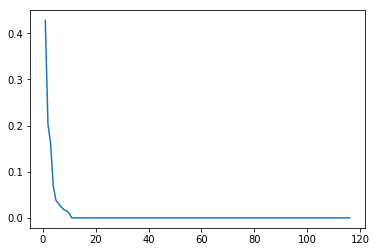

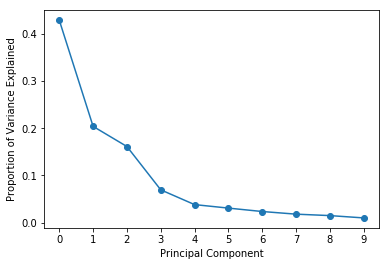

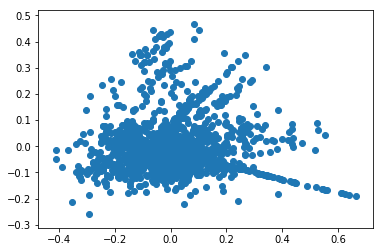

In [6]:
normalized_X_np = preprocessing.normalize(private2_schools_df)
pca_np_model = PCA()
np_PCA = pca_np_model.fit_transform(normalized_X_np)

print("The first 3 components explain ",end="")
print(round((pca_np_model.explained_variance_ratio_[0]+
       pca_np_model.explained_variance_ratio_[1]+
       pca_np_model.explained_variance_ratio_[2]),4)*100,
       "%",sep="",end="")
print(" of the variance in the data for Private Non-Profit schools.")

# Plotting the explained variance for each principle component
list_np_PCA_variances = []
for i in range(len(pca_np_model.explained_variance_ratio_)):
    list_np_PCA_variances.append(pca_np_model.explained_variance_ratio_[i])
    
print("\nThese are the principle components that explain more tha 0.1% of variance in non-profit school data")
components_to_use_np = []
for variance in list_np_PCA_variances:
    if variance > 0.001:
        components_to_use_np.append(variance)
print(components_to_use_np)

# This shows an extreme drop off for variances, which infers that we do not need a majority of these columns
# for clustering
plt.plot(np.linspace(1, len(pca_np_model.explained_variance_ratio_), 116), list_np_PCA_variances)
plt.show()
plt.plot(list(range(len(components_to_use_np))), components_to_use_np, '-o')
plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xticks(list(range(len(components_to_use_np))))
plt.show()
plt.scatter(np_PCA[:,0],np_PCA[:,1])
plt.show()

np_pca_df = pd.DataFrame(np_PCA[:,0:7], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'], 
                      index=list(private2_schools_df.iloc[:,0]))

#PCA into pickle object

np_pca_df.to_pickle("nonprofitPCA.pkl")

## PCA for For-Profit Schools

The first 3 components explain 81.85% of the variance in the data for Private For-Profit schools.

These are the principle components that explain more tha 0.1% of variance in non-profit school data
[0.37321690579646083, 0.2568119570373119, 0.18844132607621955, 0.05530799198990375, 0.042558135792988, 0.02990536800313206, 0.02531994526428815, 0.018727897177012804, 0.006514803677711037, 0.003194359417409756]


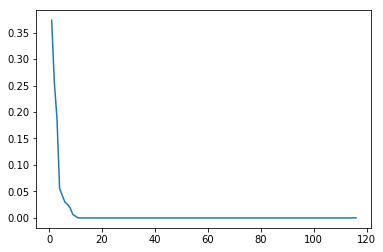

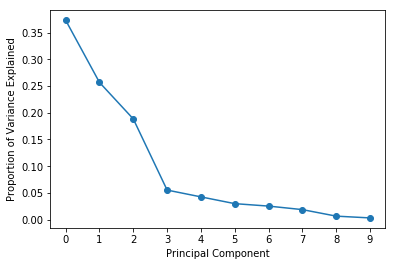

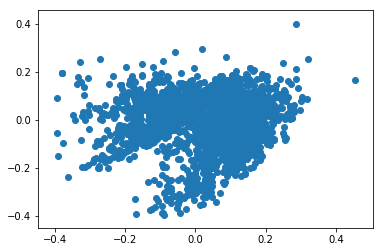

In [7]:
normalized_X_fp = preprocessing.normalize(private3_schools_df)
pca_fp_model = PCA()
fp_PCA = pca_fp_model.fit_transform(normalized_X_fp)

print("The first 3 components explain ",end="")
print(round((pca_fp_model.explained_variance_ratio_[0]+
       pca_fp_model.explained_variance_ratio_[1]+
       pca_fp_model.explained_variance_ratio_[2]),4)*100,
       "%",sep="",end="")
print(" of the variance in the data for Private For-Profit schools.")

# Plotting the explained variance for each principle component
list_fp_PCA_variances = []
for i in range(len(pca_fp_model.explained_variance_ratio_)):
    list_fp_PCA_variances.append(pca_fp_model.explained_variance_ratio_[i])
    
print("\nThese are the principle components that explain more tha 0.1% of variance in non-profit school data")
components_to_use_fp = []
for variance in list_fp_PCA_variances:
    if variance > 0.001:
        components_to_use_fp.append(variance)
print(components_to_use_fp)

# This shows an extreme drop off for variances, which infers that we do not need a majority of these columns
# for clustering
plt.plot(np.linspace(1, len(pca_fp_model.explained_variance_ratio_), 116), list_fp_PCA_variances)
plt.show()
plt.plot(list(range(len(components_to_use_fp))), components_to_use_fp, '-o')
plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xticks(list(range(len(components_to_use_fp))))
plt.show()
plt.scatter(fp_PCA[:,0], fp_PCA[:,1])
plt.show()

fp_pca_df = pd.DataFrame(fp_PCA[:,0:7], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'], 
                      index=list(private3_schools_df.iloc[:,0]))

#PCA into pickle object

fp_pca_df.to_pickle("forprofitPCA.pkl")

In [8]:
print("Median Debt from all schools:", round(imputed_df.GRAD_DEBT_MDN_SUPP.mean(),2))
print("Median Earnings 10 years after entry (All schools):", round(imputed_df.MD_EARN_WNE_P10.mean(),2))

print("Median Public School Loan Debt:", round(public_schools_df.GRAD_DEBT_MDN_SUPP.mean(),2))
print("Median Earnings 10 years after entry (public school):", round(public_schools_df.MD_EARN_WNE_P10.mean(),2))

print("Median Private Nonprofit School Loan Debt:", round(private2_schools_df.GRAD_DEBT_MDN_SUPP.mean(),2))
print("Median Earnings 10 years after entry (private NP school):", 
      round(private2_schools_df.MD_EARN_WNE_P10.mean(),2))

print("Median Private For-Profit School Loan Debt:", round(private3_schools_df.GRAD_DEBT_MDN_SUPP.mean(),2))
print("Median Earnings 10 years after entry (private FP school):", 
      round(private3_schools_df.MD_EARN_WNE_P10.mean(),2))

Median Debt from all schools: 16308.75
Median Earnings 10 years after entry (All schools): 35384.03
Median Public School Loan Debt: 14650.12
Median Earnings 10 years after entry (public school): 35963.78
Median Private Nonprofit School Loan Debt: 20921.21
Median Earnings 10 years after entry (private NP school): 41758.5
Median Private For-Profit School Loan Debt: 14292.66
Median Earnings 10 years after entry (private FP school): 30436.38


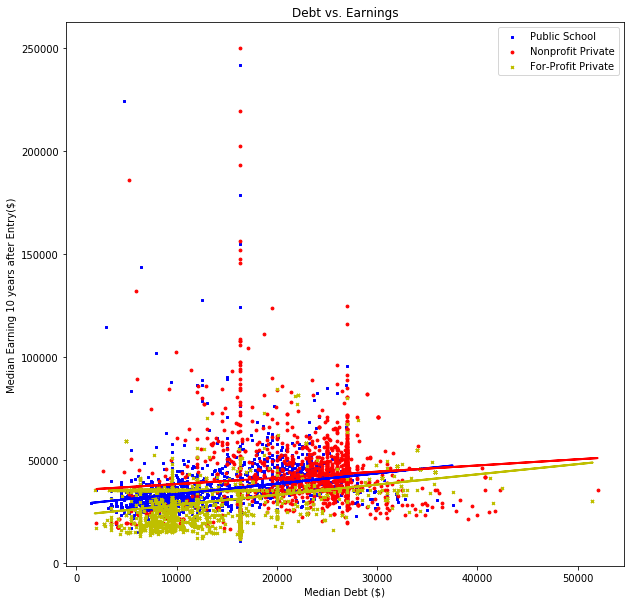

In [9]:
pubdebt = public_schools_df.GRAD_DEBT_MDN_SUPP
pubearn = public_schools_df.MD_EARN_WNE_P10
npdebt = private2_schools_df.GRAD_DEBT_MDN_SUPP
npearn = private2_schools_df.MD_EARN_WNE_P10
fpdebt = private3_schools_df.GRAD_DEBT_MDN_SUPP
fpearn = private3_schools_df.MD_EARN_WNE_P10

# create a linear regression object
publr = sm.ols(formula="MD_EARN_WNE_P10 ~ GRAD_DEBT_MDN_SUPP", data=public_schools_df, missing='drop').fit()
nplr = sm.ols(formula="MD_EARN_WNE_P10 ~ GRAD_DEBT_MDN_SUPP", data=private2_schools_df, missing='drop').fit()
fplr = sm.ols(formula="MD_EARN_WNE_P10 ~ GRAD_DEBT_MDN_SUPP", data=private3_schools_df, missing='drop').fit()

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)

ax1.scatter(pubdebt, pubearn, s=8, c='b', marker="s", label='Public School')
ax1.plot(pubdebt, publr.predict(), c='b', linewidth=2)
ax1.scatter(npdebt, npearn, s=8, c='r', marker="o", label='Nonprofit Private')
ax1.plot(npdebt, nplr.predict(), c='r', linewidth=2)
ax1.scatter(fpdebt, fpearn, s=8, c='y', marker="x", label='For-Profit Private')
ax1.plot(fpdebt, fplr.predict(), c='y', linewidth=2)
plt.legend(loc='upper right')
plt.xlabel('Median Debt ($)')
plt.ylabel('Median Earning 10 years after Entry($)')
plt.title('Debt vs. Earnings')
plt.show()